# Importing Libraries

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn import metrics


%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("Loan_data.csv")

In [5]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [7]:
print(data.shape)

(614, 13)


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


### Exploratory Analysis

##### Checking for Class Imbalance

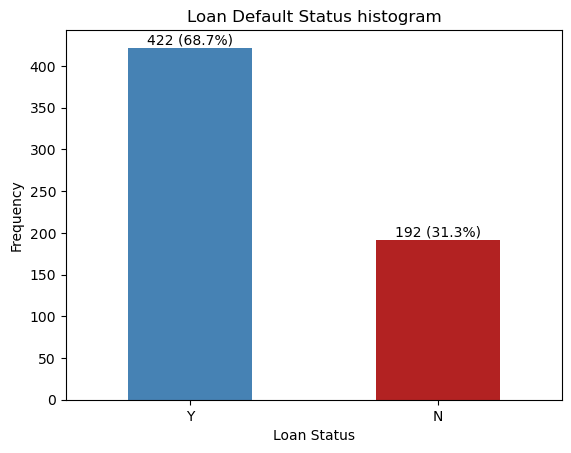

In [13]:
count_classes = data['Loan_Status'].value_counts()
percentage = (count_classes / count_classes.sum()) * 100

# Define color palette
colors = ['steelblue', 'firebrick']

ax = count_classes.plot(kind='bar', rot=0, color=colors)
ax.set_title("Loan Default Status histogram")
ax.set_xlabel("Loan Status")
ax.set_ylabel("Frequency")

# Add percentage labels to each bar
for i, v in enumerate(count_classes):
    ax.text(i, v, f"{v} ({percentage[i]:.1f}%)", ha='center', va='bottom')

plt.show()

##### Checking for missing data

In [16]:
data.apply(lambda x: sum(x.isnull()))

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [18]:
# filtered out missing rows
filtered_df = data.dropna(subset=data.columns)
filtered_df.apply(lambda x: sum(x.isnull()))

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [24]:
filtered_df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,480.000000,480.000000,480.000000,480.000000,480.000000
mean,5364.231250,1581.093583,144.735417,342.050000,0.854167
std,5668.251251,2617.692267,80.508164,65.212401,0.353307
min,150.000000,0.000000,9.000000,36.000000,0.000000
25%,2898.750000,0.000000,100.000000,360.000000,1.000000
50%,3859.000000,1084.500000,128.000000,360.000000,1.000000
75%,5852.500000,2253.250000,170.000000,360.000000,1.000000
max,81000.000000,33837.000000,600.000000,480.000000,1.000000


###### It is obvious from the above that Credit_History ranges from 0 and 1 which means it seems it is a binary category of 0 and 1 and treating as numerical data type is inappropriate.

In [210]:
credit_history_default = filtered_df.groupby(['Credit_History']).agg(total_default=('Loan_Status', lambda x: (x == 'Y').sum())).reset_index()
total_defaults = credit_history_default['total_default'].sum()
credit_history_default['percentage'] = round(credit_history_default['total_default'] / total_defaults * 100, 2)
credit_history_default

,Credit_History,total_default,percentage
0,0.0,7,2.11
1,1.0,325,97.89


In [216]:
credit_history_default = filtered_df.groupby(['Credit_History', 'Gender']).agg(total_default=('Loan_Status', lambda x: (x == 'Y').sum())).reset_index()
total_defaults = credit_history_default['total_default'].sum()
credit_history_default['percentage'] = round(credit_history_default['total_default'] / total_defaults * 100, 2)
credit_history_default

,Credit_History,Gender,total_default,percentage
0,0.0,Female,1,0.30
1,0.0,Male,6,1.81
2,1.0,Female,53,15.96
3,1.0,Male,272,81.93


***It is obvous from the above that men without credit_History (i.e credit_History = 0) has more chance o default as compared to women***

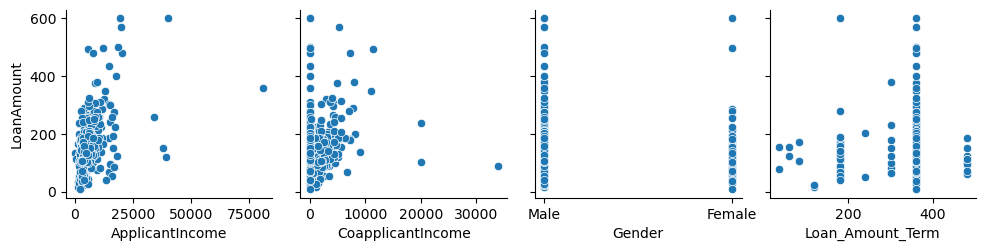

In [188]:
sns.pairplot(data=filtered_df,
                  y_vars=['LoanAmount'],
                  x_vars=['ApplicantIncome','CoapplicantIncome','Gender','Loan_Amount_Term'])

In [27]:
#changing credit history to object
filtered_df.loc[:, 'Credit_History'] = filtered_df['Credit_History'].astype(object)
filtered_df.Credit_History.info()

<class 'pandas.core.series.Series'>
Index: 480 entries, 1 to 613
Series name: Credit_History
Non-Null Count  Dtype 
--------------  ----- 
480 non-null    object
dtypes: object(1)
memory usage: 7.5+ KB


#### Distribution of the the numerical features

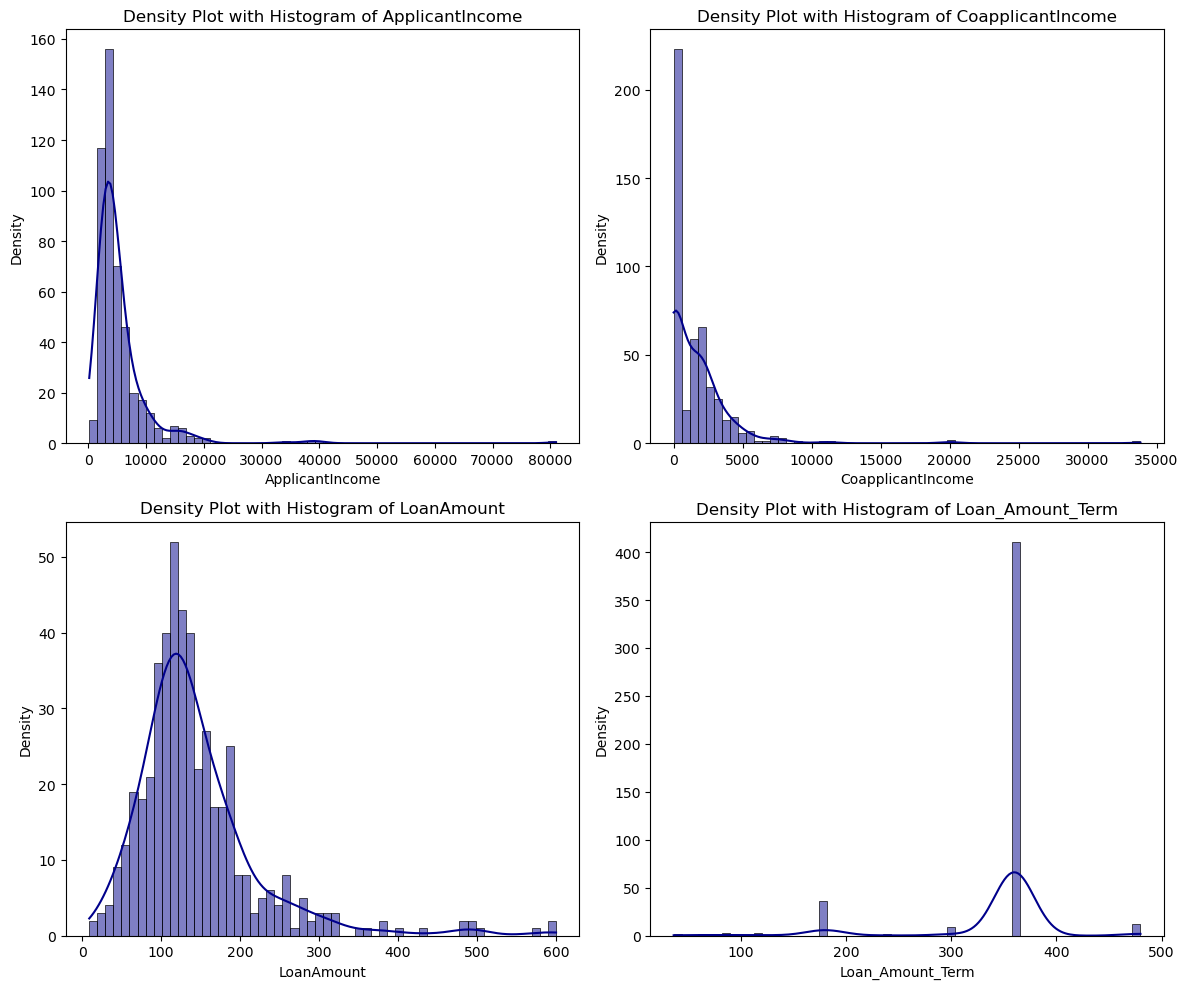

In [30]:
# Determine the number of features and calculate grid dimensions
num_features = len(filtered_df.select_dtypes(include=['number']).columns)
num_cols = 2
num_rows = (num_features - 1) // num_cols + 1

# Create subplots with grid layout
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10))
axes = axes.flatten()  # Flatten the array of axes

# Plot density plot and histogram for each numerical feature
for i, column in enumerate(filtered_df.select_dtypes(include='number')):
    sns.histplot(data=filtered_df, x=column, kde=True, ax=axes[i], bins=int(700/12), color = 'darkblue')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Density')
    axes[i].set_title(f'Density Plot with Histogram of {column}')

# Remove any unused subplots
if num_features < len(axes):
    for j in range(num_features, len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [34]:
#Encoding categorical features or variable 
X = filtered_df.drop(columns=['Loan_Status','Loan_ID'])

Y = filtered_df['Loan_Status']

X = pd.get_dummies(data=X, drop_first=True)

In [36]:
X.head(5)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Credit_History_1.0,Property_Area_Semiurban,Property_Area_Urban
1,4583,1508.0,128.0,360.0,True,True,True,False,False,False,False,True,False,False
2,3000,0.0,66.0,360.0,True,True,False,False,False,False,True,True,False,True
3,2583,2358.0,120.0,360.0,True,True,False,False,False,True,False,True,False,True
4,6000,0.0,141.0,360.0,True,False,False,False,False,False,False,True,False,True
5,5417,4196.0,267.0,360.0,True,True,False,True,False,False,True,True,False,True


In [38]:
#Create Training and Test Sets and Apply Scaling

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)

In [39]:
X_train.head(3)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Credit_History_1.0,Property_Area_Semiurban,Property_Area_Urban
566,3333,0.0,70.0,360.0,True,False,False,False,False,False,False,True,False,True
557,10139,0.0,260.0,360.0,True,True,False,False,True,False,True,True,True,False
510,3598,1287.0,100.0,360.0,True,False,False,False,False,True,False,True,False,False


In [42]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Model Building

#### Logistic Regression

In [58]:
model = LogisticRegression(solver='liblinear',C=10.0, random_state=0)
log_reg = model.fit(X_train, y_train)
log_reg

LogisticRegression(C=10.0, random_state=0, solver='liblinear')

In [60]:
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(log_reg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(log_reg.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.82
Accuracy of Logistic regression classifier on test set: 0.78


In [62]:
seed = 7
kfold = model_selection.KFold(n_splits=10)
model = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
print(("Accuracy: %.3f (%.3f)") % (results.mean(), results.std()))

Accuracy: 0.814 (0.060)


In [64]:
y_pred = log_reg.predict(X_test)

Text(0.5, 23.52222222222222, 'Predicted label')

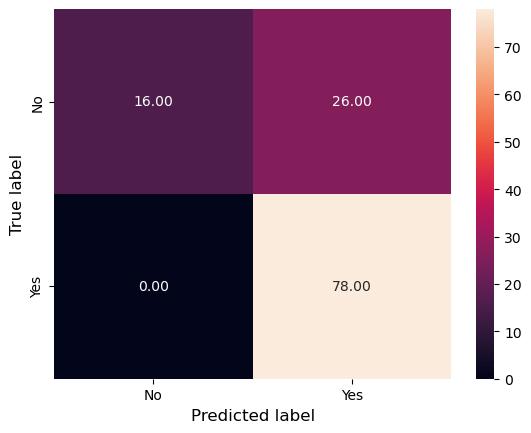

In [66]:
cm = confusion_matrix(y_test, y_pred)
sn.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["No", "Yes"] , yticklabels = ["No", "Yes"],)
plt.ylabel('True label',fontsize=12)
plt.xlabel('Predicted label',fontsize=12)

In [72]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           N       1.00      0.38      0.55        42
           Y       0.75      1.00      0.86        78

    accuracy                           0.78       120
   macro avg       0.88      0.69      0.70       120
weighted avg       0.84      0.78      0.75       120



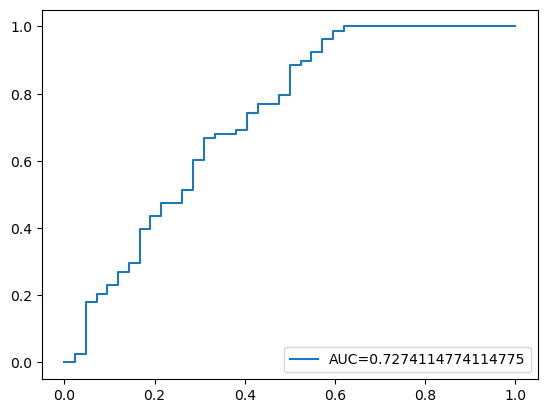

In [74]:
#define metrics
y_pred_proba = log_reg.predict_proba(X_test)[::,1]
y_test_binary = y_test.replace({'N': 0, 'Y': 1})
fpr, tpr, _ = metrics.roc_curve(y_test_binary,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()

In [76]:
importances = pd.DataFrame(data={
    'Attribute': X.columns,
    'Importance': log_reg.coef_[0]
})

importances = importances.sort_values(by='Importance', ascending=False)
print(importances)

                  Attribute  Importance
11       Credit_History_1.0    3.419190
12  Property_Area_Semiurban    1.091132
0           ApplicantIncome    0.802778
8             Dependents_3+    0.781989
7              Dependents_2    0.667174
5               Married_Yes    0.660760
4               Gender_Male    0.075517
13      Property_Area_Urban    0.057581
6              Dependents_1   -0.213813
10        Self_Employed_Yes   -0.304839
9    Education_Not Graduate   -0.406569
3          Loan_Amount_Term   -1.086270
2                LoanAmount   -1.488693
1         CoapplicantIncome   -1.930384


In [ ]:
As expected the 

#### Random Forest

In [82]:
rf = RandomForestClassifier(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [84]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000]}


In [86]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 311, 522, 733,
                                                         944, 1155, 1366, 1577,
                                                         1788, 2000]},
                   random_state=42, verbose=2)

In [87]:
rf_random.best_params_

{'n_estimators': 311,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': True}

In [90]:
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
print('Accuracy of Base_Model: {:.2f}'
     .format(base_model.score(X_test, y_test)))

Accuracy of Base_Model: 0.78


In [92]:
best_random = rf_random.best_estimator_
print('Accuracy of Best_random: {:.2f}'
     .format(best_random.score(X_test, y_test)))

Accuracy of Best_random: 0.78


In [94]:
print("The Best Random Model is",best_random.score(X_test, y_test) - base_model.score(X_test, y_test),"better than the Base_model")

The Best Random Model is 0.0 better than the Base_model


In [96]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [98]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 300}

In [99]:
best_grid = grid_search.best_estimator_
print('Accuracy of Best_grid: {:.2f}'
     .format(best_grid.score(X_test, y_test)))

Accuracy of Best_grid: 0.78


In [100]:
y_pred = best_grid.predict(X_test)

In [101]:
#from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           N       0.94      0.38      0.54        42
           Y       0.75      0.99      0.85        78

    accuracy                           0.78       120
   macro avg       0.84      0.68      0.70       120
weighted avg       0.82      0.78      0.74       120



# Decision Tree

In [106]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(max_depth = 4,random_state = 0).fit(X_train, y_train)

In [108]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(dt_clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(dt_clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 0.84
Accuracy of Decision Tree classifier on test set: 0.78


In [110]:
y_pred_clf = dt_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_clf)
cm

array([[17, 25],
       [ 2, 76]], dtype=int64)

In [112]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred_clf)
print(report)

              precision    recall  f1-score   support

           N       0.89      0.40      0.56        42
           Y       0.75      0.97      0.85        78

    accuracy                           0.78       120
   macro avg       0.82      0.69      0.70       120
weighted avg       0.80      0.78      0.75       120



[Text(0.5, 0.9, 'x[11] <= 0.5\ngini = 0.415\nsamples = 360\nvalue = [106.0, 254.0]'),
 Text(0.2777777777777778, 0.7, 'x[2] <= 0.911\ngini = 0.226\nsamples = 54\nvalue = [47, 7]'),
 Text(0.2222222222222222, 0.5, 'x[2] <= 0.203\ngini = 0.201\nsamples = 53\nvalue = [47, 6]'),
 Text(0.1111111111111111, 0.3, 'x[1] <= 0.07\ngini = 0.069\nsamples = 28\nvalue = [27, 1]'),
 Text(0.05555555555555555, 0.1, 'gini = 0.0\nsamples = 25\nvalue = [25, 0]'),
 Text(0.16666666666666666, 0.1, 'gini = 0.444\nsamples = 3\nvalue = [2, 1]'),
 Text(0.3333333333333333, 0.3, 'x[2] <= 0.276\ngini = 0.32\nsamples = 25\nvalue = [20, 5]'),
 Text(0.2777777777777778, 0.1, 'gini = 0.496\nsamples = 11\nvalue = [6, 5]'),
 Text(0.3888888888888889, 0.1, 'gini = 0.0\nsamples = 14\nvalue = [14, 0]'),
 Text(0.3333333333333333, 0.5, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.7222222222222222, 0.7, 'x[12] <= 0.5\ngini = 0.311\nsamples = 306\nvalue = [59, 247]'),
 Text(0.6111111111111112, 0.5, 'x[0] <= 0.434\ngini = 0.37

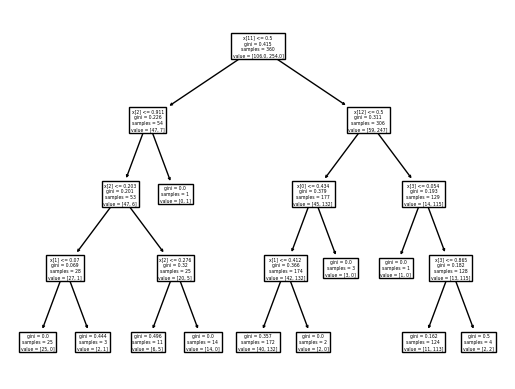

In [114]:
from sklearn import tree
tree.plot_tree(dt_clf)

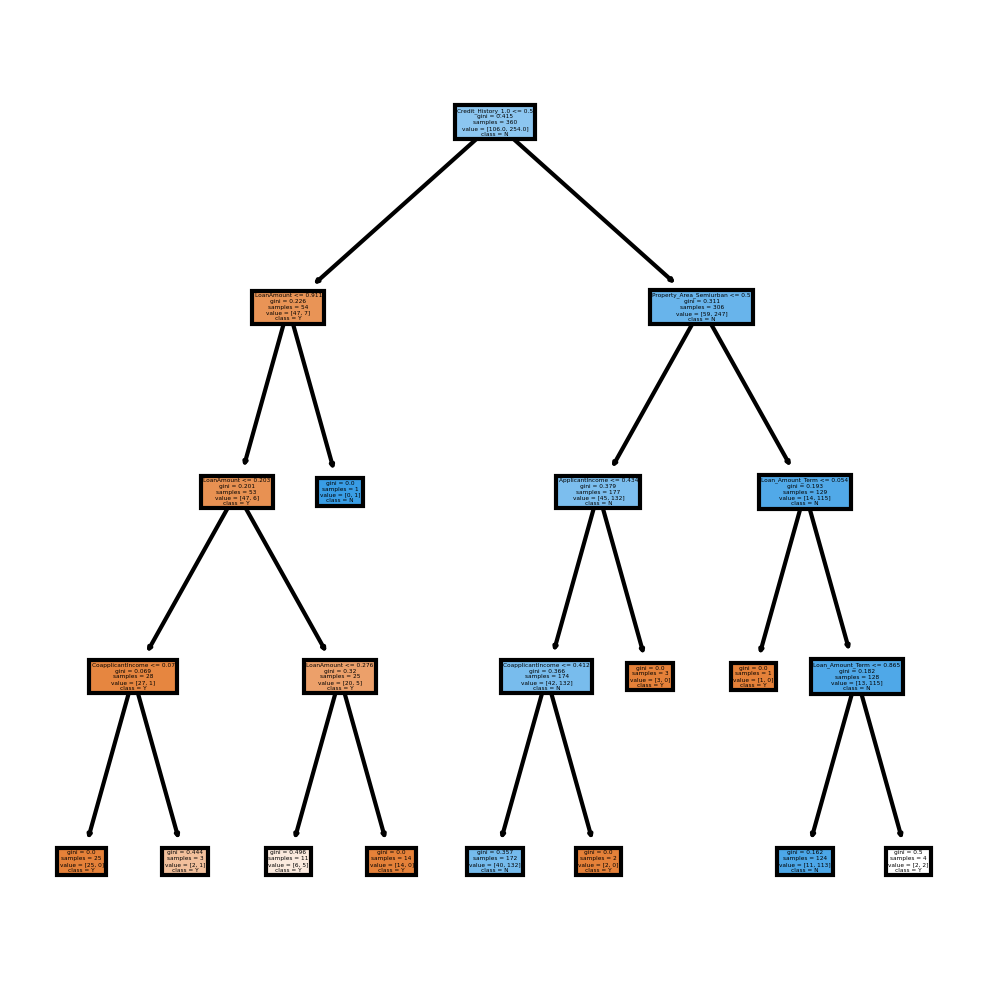

In [116]:
fn= X.columns
cn= ['Y','N']

#fig = plt.figure(figsize=(25,20))
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(dt_clf,
               feature_names = fn, 
               class_names=cn,
               filled = True);
#fig.savefig('imagename.png')

# Hyperparameter tuning for Decision Tree

For each method, I'll discuss how to search for the optimal structure of a random forest classifer. Random forests are an ensemble model comprised of a collection of decision trees; when building such a model, two important hyperparameters to consider are:

    1. How many estimators (ie. decision trees) should I use?
    2. What should be the maximum allowable depth for each decision tree?

In [118]:
from scipy.stats import randint
param_dist = {"max_depth": [3, None],
             "min_samples_leaf":randint(1,9),
             "criterion": ["gini","entropy"]}

In [120]:
from sklearn.model_selection import RandomizedSearchCV
tree = DecisionTreeClassifier()

dt_cv = RandomizedSearchCV(tree,param_dist,cv=5)
dt_cv.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000013D4807EF00>})

In [122]:
print('Tuned Decision tree parameters:{}'
     .format(dt_cv.best_params_))

print('Best Score of Decision Tree Cross Validation on training set: {:.2f}'
     .format(dt_cv.best_score_))

Tuned Decision tree parameters:{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1}
Best Score of Decision Tree Cross Validation on training set: 0.78


In [124]:
ydt_pred = dt_cv.predict(X_test)

In [126]:
#from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, ydt_pred)
cm

array([[17, 25],
       [ 1, 77]], dtype=int64)

In [128]:

report = classification_report(y_test, ydt_pred)
print(report)

              precision    recall  f1-score   support

           N       0.94      0.40      0.57        42
           Y       0.75      0.99      0.86        78

    accuracy                           0.78       120
   macro avg       0.85      0.70      0.71       120
weighted avg       0.82      0.78      0.75       120



# K Nearest Neighbour(KNN)

KNN falls in the supervised learning family of algorithms. Informally, this means that we are given a labelled dataset consiting of training observations (x,y) and would like to capture the relationship between x and y. More formally, our goal is to learn a function h:X→Y so that given an unseen observation x, h(x) can confidently predict the corresponding output y.

The KNN classifier is also a non parametric and instance-based learning algorithm.

Non-parametric 
means it makes no explicit assumptions about the functional form of h, avoiding the dangers of mismodeling the underlying distribution of the data. For example, suppose our data is highly non-Gaussian but the learning model we choose assumes a Gaussian form. In that case, our algorithm would make extremely poor predictions.

Instance-based 
learning means that our algorithm doesn’t explicitly learn a model. Instead, it chooses to memorize the training instances which are subsequently used as “knowledge” for the prediction phase. Concretely, this means that only when a query to our database is made (i.e. when we ask it to predict a label given an input), will the algorithm use the training instances to spit out an answer.

#### Value of K

At this point, you’re probably wondering how to pick the variable K and what its effects are on your classifier. Well, like most machine learning algorithms, the K in KNN is a hyperparameter that you, as a designer, must pick in order to get the best possible fit for the data set. Intuitively, you can think of K as controlling the shape of the decision boundary we talked about earlier.

When K is small, we are restraining the region of a given prediction and forcing our classifier to be “more blind” to the overall distribution. A small value for K provides the most flexible fit, which will have low bias but high variance. Graphically, our decision boundary will be more jagged.

On the other hand, a higher K averages more voters in each prediction and hence is more resilient to outliers. Larger values of K will have smoother decision boundaries which means lower variance but increased bias.

In [134]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=8, metric='minkowski').fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.80
Accuracy of K-NN classifier on test set: 0.76


In [136]:
y_pred_knn = knn.predict(X_test)
cm = confusion_matrix(y_test, y_pred_knn)
cm

array([[14, 28],
       [ 1, 77]], dtype=int64)

In [145]:
report = classification_report(y_test, y_pred_knn)
print(report)

              precision    recall  f1-score   support

           N       0.93      0.33      0.49        42
           Y       0.73      0.99      0.84        78

    accuracy                           0.76       120
   macro avg       0.83      0.66      0.67       120
weighted avg       0.80      0.76      0.72       120



Text(0, 0.5, 'Mean Error')

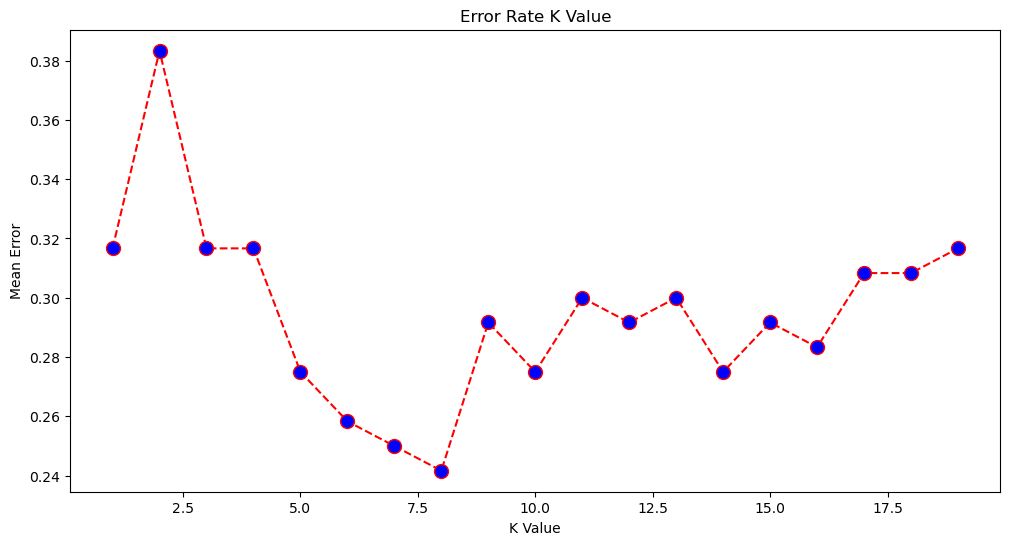

In [140]:
error = []
# Calculating error for K values between 1 and 40
for i in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))


plt.figure(figsize=(12, 6))
plt.plot(range(1, 20), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

# Parameter Tuning for KNN

In [143]:
# creating odd list of K for KNN
myList = list(range(1,50))

# subsetting just the odd ones
neighbors = list(filter(lambda x: x%2!=0, myList))

# empty list that will hold cv scores
cv_scores = []

from sklearn.model_selection import cross_val_score
# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(round(scores.mean(),4))

C:\Users\seune\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\seune\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\seune\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\seune\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\seune\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\seune\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\seune\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\seune\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\seune\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\seune\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\seune\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\seune\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\seune\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\seune\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\seune\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\seune\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\Users\seune\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [147]:
cv_scores

[0.7028,
 0.7583,
 0.7583,
 0.7417,
 0.7444,
 0.7556,
 0.7667,
 0.7556,
 0.7583,
 0.7556,
 0.7528,
 0.7444,
 0.7444,
 0.7417,
 0.7444,
 0.7361,
 0.7361,
 0.7306,
 0.7389,
 0.7417,
 0.7333,
 0.7306,
 0.725,
 0.7222,
 0.7194]

The optimal number of neighbors is 13


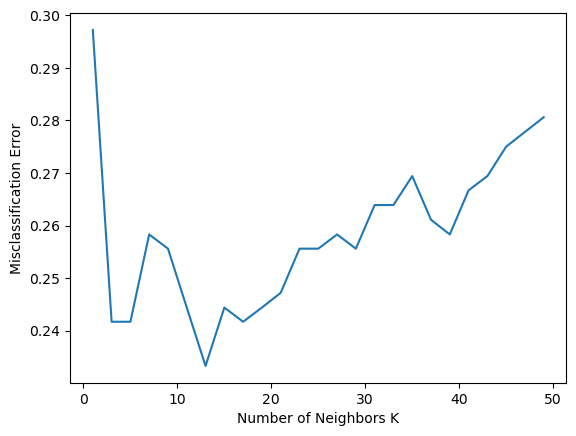

In [149]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print ("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

Now that we know the model is at optimum when the K = 13, we have to fit a new model with k = 13

In [151]:
# instantiate learning model (k = 13)
knn = KNeighborsClassifier(n_neighbors=13)

# fitting the model
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=13)

In [153]:
# predict the response
pred_knn = knn.predict(X_test)

# evaluate accuracy
from sklearn.metrics import classification_report
report = classification_report(y_test, pred_knn)
print(report)

              precision    recall  f1-score   support

           N       1.00      0.14      0.25        42
           Y       0.68      1.00      0.81        78

    accuracy                           0.70       120
   macro avg       0.84      0.57      0.53       120
weighted avg       0.79      0.70      0.62       120



In [155]:
y_pred_knn = knn.predict(X_test)
cm = confusion_matrix(y_test, pred_knn)
cm

array([[ 6, 36],
       [ 0, 78]], dtype=int64)

# Linear Discriminant Analysis

In [158]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis().fit(X_train, y_train)
lda

LinearDiscriminantAnalysis()

In [160]:
print('Accuracy of LDA classifier on training set: {:.2f}'
     .format(lda.score(X_train, y_train)))
print('Accuracy of LDA classifier on test set: {:.2f}'
     .format(lda.score(X_test, y_test)))


Accuracy of LDA classifier on training set: 0.82
Accuracy of LDA classifier on test set: 0.78


In [162]:
y_pred_lda = lda.predict(X_test)
cm = confusion_matrix(y_test, y_pred_lda)
cm

array([[16, 26],
       [ 0, 78]], dtype=int64)

In [164]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred_lda)
print(report)

              precision    recall  f1-score   support

           N       1.00      0.38      0.55        42
           Y       0.75      1.00      0.86        78

    accuracy                           0.78       120
   macro avg       0.88      0.69      0.70       120
weighted avg       0.84      0.78      0.75       120



# Gaussian Naive Bayes

In [167]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(X_train, y_train)
gnb

GaussianNB()

In [169]:
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(gnb.score(X_test, y_test)))

Accuracy of GNB classifier on training set: 0.81
Accuracy of GNB classifier on test set: 0.77


In [171]:
y_pred_gnb = lda.predict(X_test)
cm = confusion_matrix(y_test, y_pred_gnb)
cm

array([[16, 26],
       [ 0, 78]], dtype=int64)

In [173]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred_gnb)
print(report)

              precision    recall  f1-score   support

           N       1.00      0.38      0.55        42
           Y       0.75      1.00      0.86        78

    accuracy                           0.78       120
   macro avg       0.88      0.69      0.70       120
weighted avg       0.84      0.78      0.75       120



# Support Vector Analysis

In [176]:
from sklearn.svm import SVC
svm = SVC().fit(X_train, y_train)
svm

SVC()

In [178]:
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))


Accuracy of SVM classifier on training set: 0.82
Accuracy of SVM classifier on test set: 0.78


In [180]:
y_pred_svm = svm.predict(X_test)
cm = confusion_matrix(y_test, y_pred_svm)
cm


array([[15, 27],
       [ 0, 78]], dtype=int64)

In [182]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred_svm)
print(report)

              precision    recall  f1-score   support

           N       1.00      0.36      0.53        42
           Y       0.74      1.00      0.85        78

    accuracy                           0.78       120
   macro avg       0.87      0.68      0.69       120
weighted avg       0.83      0.78      0.74       120



# Gradient Boosting

In [190]:
#Import Library
from sklearn.ensemble import GradientBoostingClassifier
#Assumed you have, X (predictor) and Y (target) for training data set and x_test(predictor) of test_dataset
# Create Gradient Boosting Classifier object
model= GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
gra_b = model.fit(X_train, y_train)

In [192]:
print('Accuracy of gra_b classifier on training set: {:.2f}'
     .format(gra_b.score(X_train, y_train)))
print('Accuracy of gra_b classifier on test set: {:.2f}'
     .format(gra_b.score(X_test, y_test)))

Accuracy of gra_b classifier on training set: 0.90
Accuracy of gra_b classifier on test set: 0.70


In [194]:
from sklearn.metrics import confusion_matrix
y_pred_gra_b = gra_b.predict(X_test)
cm = confusion_matrix(y_test, y_pred_gra_b)
cm

array([[19, 23],
       [13, 65]], dtype=int64)

In [196]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred_gra_b)
print(report)

              precision    recall  f1-score   support

           N       0.59      0.45      0.51        42
           Y       0.74      0.83      0.78        78

    accuracy                           0.70       120
   macro avg       0.67      0.64      0.65       120
weighted avg       0.69      0.70      0.69       120



# Results in Table

In [ ]:
accuracy_results = []
Precision_results = []
Recall_results = []

y_true_val = list(y_test.values())

# Append the results into lists
for y_pred in results:
    accuracy_results.append(classification_report(y_true_val, y_pred))
    Precision_results.append(y_true_val, y_pred)

## Exporting Data to Excel

In [ ]:
X.to_excel('r"C:\\Users\\seune\\desktop\\Dataset\\Loan_Data\\data_set_2.xlsx')